In [178]:
import torch
import json
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np

from recsysconfident.environment import Environment
from recsysconfident.ml.ranking.rank_helper import get_low_rank_items
from recsysconfident.setup import Setup


In [155]:
setup_uri = "../runs/learn-rank/ml-1m-learn-rank-dgatpredconf-1/setup-1.json"
setup = Setup(**json.loads(open(setup_uri).read()))
environ = Environment(model_name=setup.model_name,
                          database_name=setup.database_name,
                          instance_dir=setup.instance_dir,
                          split_position=1,
                          batch_size=setup.batch_size,
                          conf_calibration=setup.conf_calibration,
                          min_inter_per_user=setup.min_inter_per_user,
                          learn_to_rank=True,
                      root_path="../"
                          ).read_split_datasets(False)
model, fit_dl, val_dl, test_dl = environ.get_model_dataloaders()

/home/joel/Documents/confidence-rec-sys/recsysconfident/data_handling/datasets/csv_reader.py:21: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(ratings_uri, header=None, sep=self.info.sep)


6034 mapped users sequentially!
Gathered dataset with 574376 interactions, 6034 users and 3125 items.
Interactions dataset built.


/home/joel/Documents/confidence-rec-sys/recsysconfident/data_handling/datasets/csv_reader.py:21: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(ratings_uri, header=None, sep=self.info.sep)


6034 mapped users sequentially!
Gathered dataset with 574376 interactions, 6034 users and 3125 items.
Interactions dataset built.


/home/joel/Documents/confidence-rec-sys/recsysconfident/ml/models/learn_rank/dgat_pred_conf.py:45: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  nn.init.xavier_uniform(self.fc1.weight)
/home/joel/Documents/confidence-rec-sys/recsysconfident/ml/models/learn_rank/dgat_pred_conf.py:46: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  nn.init.xavier_uniform(self.fc2.weight)
/home/joel/Documents/confidence-rec-sys/recsysconfident/ml/models/learn_rank/dgat_pred_conf.py:47: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  nn.init.xavier_uniform(self.fc_conf.weight)
/home/joel/Documents/confidence-rec-sys/recsysconfident/ml/models/learn_rank/dgat_pred_conf.py:48: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  self.switch_to_main_train()


In [156]:
eval_df = environ.dataset_info.val_df

In [157]:
u_ids = torch.tensor(eval_df[environ.dataset_info.user_col].values)
p_i_ids = torch.tensor(eval_df[environ.dataset_info.item_col].values)

In [158]:
n_i_ids = get_low_rank_items(u_ids, model.items_per_user, model.n_items)

In [159]:
p_u_emb = model.ui_lookup(u_ids)
p_i_emb = model.ui_lookup(p_i_ids + environ.dataset_info.n_users)
n_i_emb = model.ui_lookup(n_i_ids + environ.dataset_info.n_users)

In [160]:
pos_scores = model(u_ids, p_i_ids)
neg_scores = model(u_ids, n_i_ids)

In [161]:
#error = (neg_scores[:, 0] >= pos_scores[:, 0]).float()
error = -torch.log(torch.sigmoid(pos_scores[:, 0] - neg_scores[:, 0])).detach()

In [162]:
sim_p = torch.cosine_similarity(p_u_emb, p_i_emb).detach()
sim_n = torch.cosine_similarity(p_u_emb, n_i_emb).detach()

sim_p = (sim_p + 1) /2
sim_n = (sim_n + 1) /2

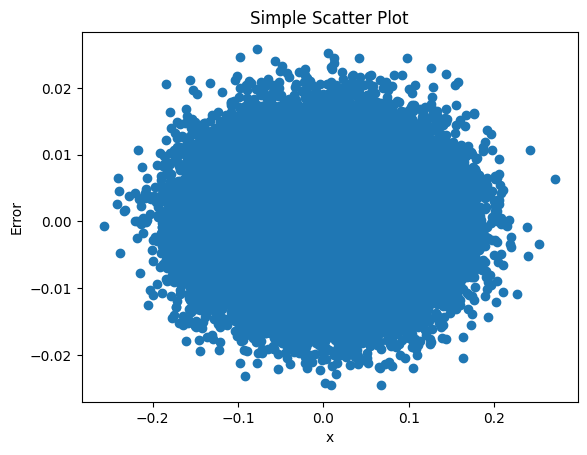

In [177]:
x = sim_p - sim_p.mean()
y = error - error.mean()
plt.scatter(x, y)

plt.xlabel('x')
plt.ylabel('Error')
plt.title('Simple Scatter Plot')

plt.show()

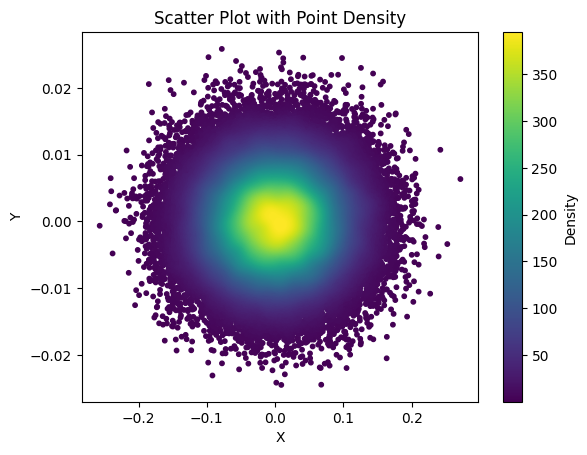

In [179]:
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# Sort points by density so that high density plots on top
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

# Create scatter plot with density colormap
plt.scatter(x, y, c=z, s=10, cmap='viridis')
plt.colorbar(label='Density')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot with Point Density')
plt.show()

In [176]:
np.corrcoef(x, -y)

array([[ 1.00000000e+00, -6.02734567e-04],
       [-6.02734567e-04,  1.00000000e+00]])